In [5]:
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fastai.tabular.all as fai_tab

pd.options.display.max_columns = 0

In [2]:
from kaggle import api

In [6]:
comp = "bluebook-for-bulldozers"
path = Path(f"./data/{comp}")

if not path.exists():
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))
    (path/f'{comp}.zip').unlink()

100%|██████████| 48.4M/48.4M [00:08<00:00, 5.88MB/s]


In [8]:
def clean_data(df: pd.DataFrame):
    data = df.copy()
    data = data.sort_values(by='saledate', ascending=True)

    """
    fiModelDesc is just the combination of fiBaseModel, fiSecondaryDesc, 
    fiModelSeries, and fiModelDescriptor. Richer information is likely to be 
    extracted when using them individually, so we won't use fiModelDesc.
    """
    data = data.drop(['fiModelDesc'], axis=1)

    """
    Many of the latter columns have "None or Unspecified" listed instead of "blank",
    where the two seem to be functionally the same. To maintain consistency, 
    we will make "None or Unspecified" blank.
    """
    data.replace('None or Unspecified', np.nan, inplace=True)

    """
    fiProductClassDesc contains the ProductGroupDesc as well as a descriptor of 
    the "primary size basis" and the range of the size (when present). 
    The size basis and range can be dropped from the product group desc by 
    removing all up to the first " - ". 
    """
    data['sizeBasis'] = (data['fiProductClassDesc']
        .str.replace(r'.* - ', '', regex=True)
    )
    data = data.drop('fiProductClassDesc', axis=1)

    # ProductGroup is just ProductGroupDesc abbreviated
    data = data.drop('ProductGroup', axis=1)

    # Create date columns
    data['saledate'] = pd.to_datetime(data['saledate'])
    data['saleyear'] = data['saledate'].dt.year
    data['salemonth'] = data['saledate'].dt.month
    data['saleday'] = data['saledate'].dt.day
    data['saledayofweek'] = data['saledate'].dt.day_of_week
    data = data.drop('saledate', axis=1)

    # Make sure tire size is consistent (some have " other inch) and make it a float
    data['Tire_Size'] = pd.to_numeric(
        data['Tire_Size'].str.replace('"', '', regex=True)
            .str.replace(' inch', '', regex=True)
    )

    # Convert stick length to inches
    data['Stick_Length'] = (
        pd.to_numeric(data['Stick_Length'].str.split("'").str[0]) * 12 \
            + pd.to_numeric(data['Stick_Length'].str.split("'").str[1].replace('"', '', regex=True)
                .str.strip())
    )

    # Undercarriage_Pad_Width to int
    data['Undercarriage_Pad_Width'] = pd.to_numeric(
        data['Undercarriage_Pad_Width'].str.replace(' inch', '', regex=True)
    )
    
    return data

In [11]:
dep_var = 'SalePrice'

In [9]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df = clean_data(df)

In [12]:
# Splits columns into categorical when cardinality is under 9000
# This is a huge dataset (400k rows) so cardinality of 9k is a very small amount of unique vals
# In neural networks, categorical columns are best handled with embeddings
cont_nn, cat_nn = fai_tab.cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [16]:
cond = (df['saleyear']<2011) | (df['salemonth']<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [17]:
procs_nn = [fai_tab.Categorify, fai_tab.FillMissing, fai_tab.Normalize]
to_nn = fai_tab.TabularPandas(
    df, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var
)

In [18]:
dls = to_nn.dataloaders(1024)

In [19]:
y = to_nn.train.y
y.min(), y.max()

(4750.0, 142000.0)

In [20]:
learn = fai_tab.tabular_learner(dls, y_range=(4750, 142000), layers=[500, 250],
                                n_out=1, loss_func=fai_tab.F.mse_loss)

SuggestedLRs(valley=0.0030199517495930195)

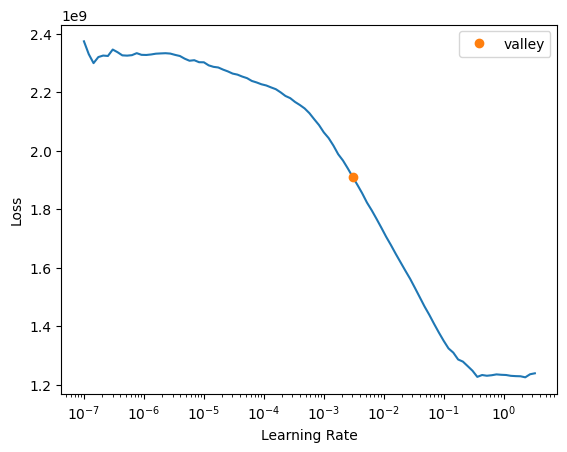

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,84097672.000000,88346912.000000,00:05
1,62580160.000000,109883616.000000,00:05
2,55481900.000000,72248536.000000,00:05
3,47796100.000000,67947488.000000,00:05
4,42108860.000000,67911400.000000,00:05


In [23]:
from sklearn.metrics import mean_squared_log_error

In [24]:
preds, targs = learn.get_preds()
# Solid first place :)
round(
    mean_squared_log_error(targs, preds, squared=False),
    5
)

0.22161